

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import pandas as pd
import PIL
from tqdm import trange
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

#file paths
#/kaggle/input/simpsons4/train
#/kaggle/input/simpsons4/testset/testset

CUDA is available!  Training on GPU ...


In [ ]:
# Download the dataset
#!kaggle competitions download -c journey-springfield


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

In [ ]:
#!ls /content/gdrive/My\ Drive/journey-springfield/train/


В нашем тесте будет 990 картинок, для которых вам будет необходимо предсказать класс.

In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
# разные режимы датасета
import torch
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
from numpy import random
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [5]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
        
        elif self.mode == 'train':
            transform = transforms.Compose([ 
            #transforms.ToPILImage(),
            transforms.RandomChoice( 
                  [transforms.ColorJitter(0.5, 0.5),
                  transforms.RandomPerspective(),
                  transforms.RandomGrayscale(),
                  transforms.RandomHorizontalFlip(),
                  transforms.RandomVerticalFlip(), 
                  transforms.RandomRotation(180)]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            x = self.load_sample(self.files[index])
            x = self._prepare_sample(x)
            x = transform(x)            
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('/kaggle/input/simpsons/train/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/simpsons/testset/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

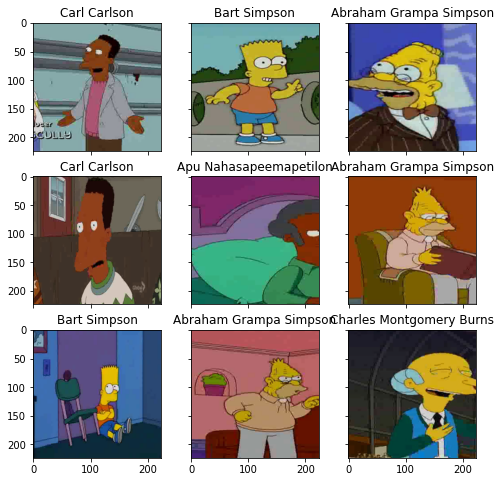

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [11]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in trange(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [18]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')


FOLD 1


  0%|          | 0/10 [00:00<?, ?it/s]

loss 2.5797709538491556


                                                      
 10%|█         | 1/10 [05:01<45:16, 301.85s/it]


Epoch 001 train_loss: 2.5798     val_loss 1.9777 train_acc 0.2774 val_acc 0.4682
loss 1.6283324489367987


                                                      
 20%|██        | 2/10 [07:44<29:19, 219.99s/it]


Epoch 002 train_loss: 1.6283     val_loss 1.4416 train_acc 0.5528 val_acc 0.6105
loss 1.099391659350004


                                                      
 30%|███       | 3/10 [10:25<22:32, 193.23s/it]


Epoch 003 train_loss: 1.0994     val_loss 1.1607 train_acc 0.6977 val_acc 0.7058
loss 0.7648120256659379


                                                      
 40%|████      | 4/10 [13:09<18:10, 181.69s/it]


Epoch 004 train_loss: 0.7648     val_loss 1.0452 train_acc 0.7850 val_acc 0.7365
loss 0.5640309709752601


                                                      
 50%|█████     | 5/10 [15:52<14:33, 174.71s/it]


Epoch 005 train_loss: 0.5640     val_loss 1.0956 train_acc 0.8354 val_acc 0.7478
loss 0.4218296262642168


                                                      
 60%|██████    | 6/10 [18:35<11:23, 170.80s/it]


Epoch 006 train_loss: 0.4218     val_loss 1.0734 train_acc 0.8795 val_acc 0.7680
loss 0.3181875543650847


                                                      
 70%|███████   | 7/10 [21:20<08:26, 168.96s/it]


Epoch 007 train_loss: 0.3182     val_loss 1.0572 train_acc 0.9048 val_acc 0.7816
loss 0.22104675848823171


                                                      
 80%|████████  | 8/10 [24:05<05:35, 167.79s/it]


Epoch 008 train_loss: 0.2210     val_loss 1.3436 train_acc 0.9318 val_acc 0.7635
loss 0.22290784854672793


                                                      
 90%|█████████ | 9/10 [27:04<02:51, 171.07s/it]


Epoch 009 train_loss: 0.2229     val_loss 1.2342 train_acc 0.9303 val_acc 0.7711
loss 0.13925654687353123


                                                       
epoch: 100%|██████████| 10/10 [29:53<00:00, 179.33s/it]



Epoch 010 train_loss: 0.1393     val_loss 1.5382 train_acc 0.9569 val_acc 0.7688


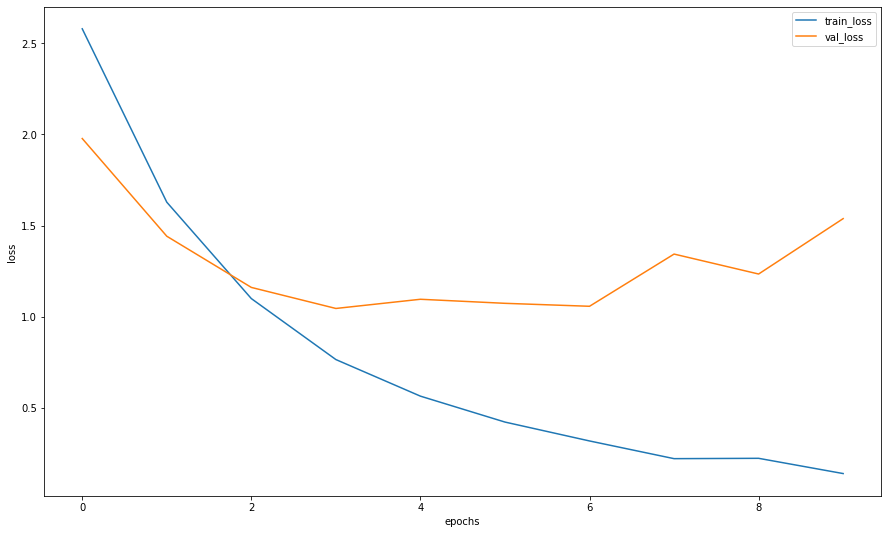

  0%|          | 0/10 [00:00<?, ?it/s]


FOLD 2
loss 0.570508583183145


                                                      
 10%|█         | 1/10 [02:41<24:12, 161.37s/it]


Epoch 001 train_loss: 0.5705     val_loss 0.3045 train_acc 0.8669 val_acc 0.9252
loss 0.3222679961970612


                                                      
 20%|██        | 2/10 [05:21<21:25, 160.64s/it]


Epoch 002 train_loss: 0.3223     val_loss 0.2011 train_acc 0.9167 val_acc 0.9428
loss 0.22277011606016067


                                                      
 30%|███       | 3/10 [08:04<18:53, 161.93s/it]


Epoch 003 train_loss: 0.2228     val_loss 0.2580 train_acc 0.9358 val_acc 0.9226
loss 0.12728735502797273


                                                      
 40%|████      | 4/10 [11:03<16:51, 168.55s/it]


Epoch 004 train_loss: 0.1273     val_loss 0.2725 train_acc 0.9637 val_acc 0.9225
loss 0.10499805074274561


                                                      
 50%|█████     | 5/10 [13:53<14:05, 169.01s/it]


Epoch 005 train_loss: 0.1050     val_loss 0.3495 train_acc 0.9664 val_acc 0.9020
loss 0.10564160582708997


                                                      
 60%|██████    | 6/10 [16:49<11:24, 171.25s/it]


Epoch 006 train_loss: 0.1056     val_loss 0.4267 train_acc 0.9651 val_acc 0.8961
loss 0.06145519284349281


                                                      
 70%|███████   | 7/10 [19:35<08:29, 169.77s/it]


Epoch 007 train_loss: 0.0615     val_loss 0.4090 train_acc 0.9811 val_acc 0.9069
loss 0.06335765924484915


                                                      
 80%|████████  | 8/10 [22:18<05:35, 167.53s/it]


Epoch 008 train_loss: 0.0634     val_loss 0.4951 train_acc 0.9806 val_acc 0.8929
loss 0.062092095348965315


                                                      
 90%|█████████ | 9/10 [25:02<02:46, 166.29s/it]


Epoch 009 train_loss: 0.0621     val_loss 0.5722 train_acc 0.9799 val_acc 0.8798
loss 0.05443296592596112


                                                       
epoch: 100%|██████████| 10/10 [27:45<00:00, 166.50s/it]



Epoch 010 train_loss: 0.0544     val_loss 0.6360 train_acc 0.9831 val_acc 0.8710


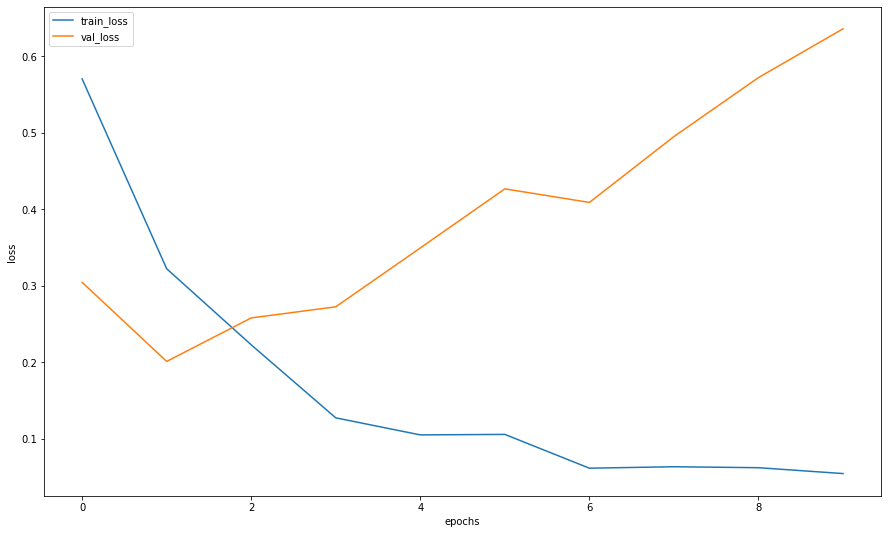

  0%|          | 0/10 [00:00<?, ?it/s]


FOLD 3
loss 0.2620577485492524


epoch:  10%|█         | 1/10 [02:45<24:45, 165.03s/it]
                                                      
 10%|█         | 1/10 [02:45<24:45, 165.04s/it]


Epoch 001 train_loss: 0.2621     val_loss 0.0750 train_acc 0.9319 val_acc 0.9824
loss 0.09819480342636733


epoch:  20%|██        | 2/10 [05:28<21:52, 164.01s/it]
                                                      
 20%|██        | 2/10 [05:28<21:52, 164.02s/it]


Epoch 002 train_loss: 0.0982     val_loss 0.0779 train_acc 0.9727 val_acc 0.9753
loss 0.060530175890279175


epoch:  30%|███       | 3/10 [08:10<19:02, 163.19s/it]
                                                      
 30%|███       | 3/10 [08:10<19:02, 163.20s/it]


Epoch 003 train_loss: 0.0605     val_loss 0.0870 train_acc 0.9813 val_acc 0.9729
loss 0.07340347798000386


epoch:  40%|████      | 4/10 [10:52<16:16, 162.68s/it]
                                                      
 40%|████      | 4/10 [10:52<16:16, 162.69s/it]


Epoch 004 train_loss: 0.0734     val_loss 0.1365 train_acc 0.9757 val_acc 0.9589
loss 0.05487970054059138


epoch:  50%|█████     | 5/10 [13:37<13:37, 163.47s/it]
                                                      
 50%|█████     | 5/10 [13:37<13:37, 163.47s/it]


Epoch 005 train_loss: 0.0549     val_loss 0.1606 train_acc 0.9826 val_acc 0.9514
loss 0.060379806575724386


epoch:  60%|██████    | 6/10 [16:22<10:55, 163.97s/it]
                                                      
 60%|██████    | 6/10 [16:22<10:55, 163.97s/it]


Epoch 006 train_loss: 0.0604     val_loss 0.1934 train_acc 0.9818 val_acc 0.9435
loss 0.05332676714290902


epoch:  70%|███████   | 7/10 [19:03<08:08, 163.00s/it]
                                                      
 70%|███████   | 7/10 [19:03<08:09, 163.00s/it]


Epoch 007 train_loss: 0.0533     val_loss 0.2484 train_acc 0.9829 val_acc 0.9375
loss 0.05745236202460514


epoch:  80%|████████  | 8/10 [21:47<05:26, 163.35s/it]
                                                      
 80%|████████  | 8/10 [21:47<05:26, 163.35s/it]


Epoch 008 train_loss: 0.0575     val_loss 0.2138 train_acc 0.9829 val_acc 0.9431
loss 0.05337026810679797


epoch:  90%|█████████ | 9/10 [24:33<02:44, 164.25s/it]
                                                      
 90%|█████████ | 9/10 [24:33<02:44, 164.25s/it]


Epoch 009 train_loss: 0.0534     val_loss 0.2233 train_acc 0.9828 val_acc 0.9435
loss 0.03355247459320181


epoch: 100%|██████████| 10/10 [27:21<00:00, 165.46s/it]
                                                       
epoch: 100%|██████████| 10/10 [27:21<00:00, 164.18s/it]



Epoch 010 train_loss: 0.0336     val_loss 0.2308 train_acc 0.9905 val_acc 0.9392


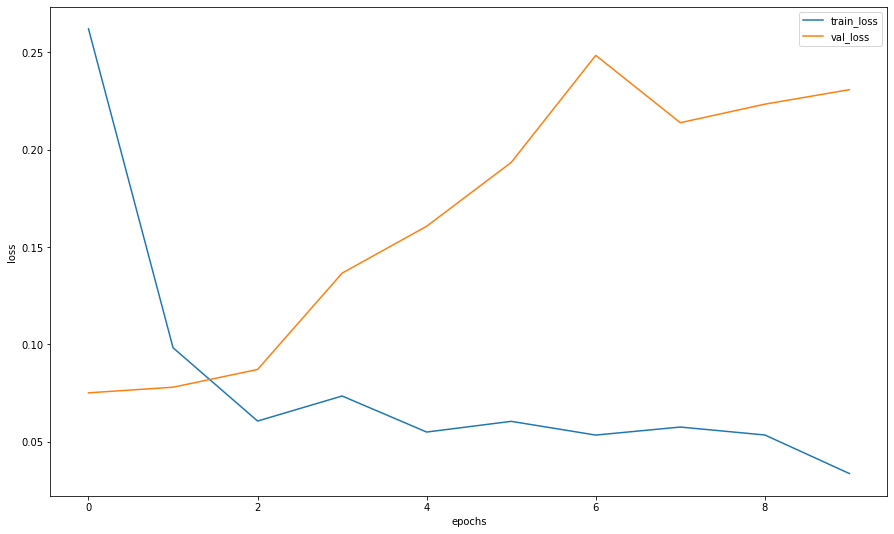

In [19]:
from sklearn.model_selection import StratifiedKFold
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
n_folds = 3
EPOCHS = 10
BATCH_SIZE = 64
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

submit = pd.DataFrame(columns=['Id'])
for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    #simple_cnn = simple_cnn.cuda()
    model = simple_cnn.to(DEVICE)
    history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [20]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [21]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [22]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

### Submit на Kaggle

In [23]:
submit['Expected'] = submit.mode(axis=1)[0]

In [24]:
submit[['Id', 'Expected']].to_csv('submission.csv', index=False)

In [25]:
submit

,Id,fold_1,fold_2,fold_3,Expected
0,NaN,nelson_muntz,barney_gumble,nelson_muntz,nelson_muntz
1,NaN,bart_simpson,bart_simpson,bart_simpson,bart_simpson
2,NaN,ned_flanders,ned_flanders,ned_flanders,ned_flanders
3,NaN,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum
4,NaN,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon,apu_nahasapeemapetilon
...,...,...,...,...,...
986,NaN,nelson_muntz,nelson_muntz,nelson_muntz,nelson_muntz
987,NaN,ned_flanders,ned_flanders,ned_flanders,ned_flanders
988,NaN,charles_montgomery_burns,charles_montgomery_burns,charles_montgomery_burns,charles_montgomery_burns
989,NaN,chief_wiggum,chief_wiggum,chief_wiggum,chief_wiggum


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

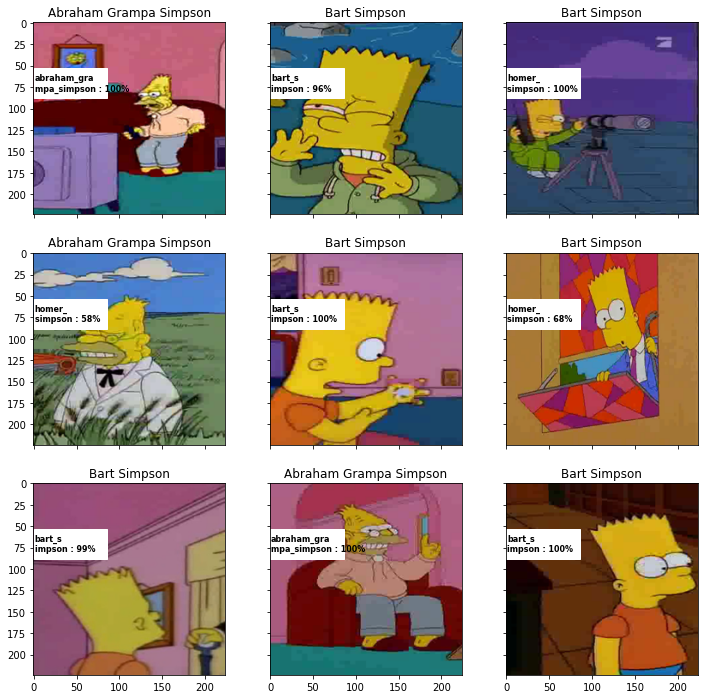

In [29]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')